In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/profiles.csv")

## Remove unneeded variables

First, let's drop all the columns we won't use.

In [3]:
df.drop(['last_online', 'location', 'sign', 'speaks', "ethnicity"], axis=1, inplace=True)
df.drop([f"essay{n}" for n in np.arange(0,10)], axis=1, inplace=True)

## Refactor "diet" variable

The "diet" variable has 6 possible cuisines (anything, vegetarian, vegan, kosher, halal, and other) and 2 changers (mostly/strictly), which might create unnecessary dummy variables that won't add value to the model. So let's boil it down to diet type without the nuance.

In [4]:
df.dropna(axis=0, subset=['diet'], inplace=True)
df['vegetarian'] = df['diet'].apply(lambda x: 1 if ("vegetarian" in x) or ("vegan" in x) else 0)
df.drop("diet", axis=1, inplace=True)

## Convert "drink" values into a numerical scale

In [5]:
df["alcohol_problem"] = df['drinks'].apply(lambda x: 1 if (x=="very often") or (x=="desperately") else 0)
df.drop("drinks", axis=1, inplace=True)

df["drugs_problem"] = df['drugs'].apply(lambda x: 1 if (x=="often") else 0)
df.drop("drugs", axis=1, inplace=True)

df['both_problems'] = df["drugs_problem"] & df["alcohol_problem"]

df['alcohol_problem_only'] = df['alcohol_problem'] & ~df['drugs_problem']
df['drugs_problem_only'] = ~df['alcohol_problem'] & df['drugs_problem']

In [6]:
df['abuse'] = df['alcohol_problem'] | df['drugs_problem']

In [7]:
df['abuse'].sum()

775

## Extract offspring

In [8]:
df.dropna(axis=0, subset=["offspring"], inplace=True)
df['offspring'].replace(['doesn&rsquo;t have kids',
                         'doesn&rsquo;t have kids, and doesn&rsquo;t want any',
                         'doesn&rsquo;t have kids, but might want them',
                         'doesn&rsquo;t have kids, but wants them',
                         'might want kids',
                         'doesn&rsquo;t want kids',
                         'wants kids'], 0, inplace=True)

df['offspring'].replace(['has a kid',
                         'has a kid, and might want more',
                         'has a kid, and wants more',
                         'has a kid, but doesn&rsquo;t want more',
                         'has kids',
                         'has kids, and might want more',
                         'has kids, and wants more',
                         'has kids, but doesn&rsquo;t want more',], 1, inplace=True)

## Cleaning up religion

Let's remove the religion variable modifiers.

In [9]:
df.dropna(axis=0, subset=["religion"], inplace=True)
df['religious'] = df['religion'].apply(lambda x: 1 if "very serious" in x else 0)
df['religious'] = ~df['religion'].isin(["agnosticism", "atheism"]) & df['religious'] == 1
df['religion'].replace([" and laughing about it",
                       " and somewhat serious about it",
                       " and very serious about it",
                       " but not too serious about it"], "", regex=True, inplace=True)

In [10]:
df['religion']

0         agnosticism
1         agnosticism
5             atheism
7        christianity
8        christianity
             ...     
59934         judaism
59936         atheism
59942     agnosticism
59943    christianity
59944     agnosticism
Name: religion, Length: 13638, dtype: object

## Extract pet information

In [11]:
df["pets"].fillna("Unknown", inplace=True)
df['has_dogs'] = df['pets'].apply(lambda x: 1 if ("has dogs" in x) else 0)
df['has_cats'] = df['pets'].apply(lambda x: 1 if ("has cats" in x) else 0)
df['has_pets'] = df[['has_dogs', 'has_cats']].any(axis=1)
df.drop('pets', axis=1, inplace=True)

## Create dummy variables from categorical columns

In [12]:
def create_dummy(df):
    """
    Creates dummy variables for all the categorial variables in a DataFrame and concatenates it
    with the original numerical columns.
    Input: pandas DataFrame
    Output: pandas DataFrame
    """
    cat_cols = df.select_dtypes(include="object").columns
    num_cols = df.select_dtypes(exclude="object").columns
    dummy_df = pd.get_dummies(df[cat_cols],
                              prefix=cat_cols,
                              prefix_sep="_",
                              dummy_na=True,
                              columns=cat_cols)
                              
    df_new = pd.concat([df[num_cols], dummy_df], axis=1)
    return df_new

In [13]:
df_dummy = pd.concat([create_dummy(df), df[['job', 'religion', 'status']], ], axis=1)

In [14]:
sns.set_theme(style="whitegrid")

### Which profession has the largest probability of substance abuse?

In [15]:
job_relative = df_dummy.groupby("job")['abuse'].mean().sort_values().to_frame()
job_relative

,abuse
job,
transportation,0.009434
banking / financial / real estate,0.009940
education / academia,0.010297
science / tech / engineering,0.012090
retired,0.016807
medicine / health,0.016842
executive / management,0.018377
sales / marketing / biz dev,0.019231
clerical / administrative,0.020408


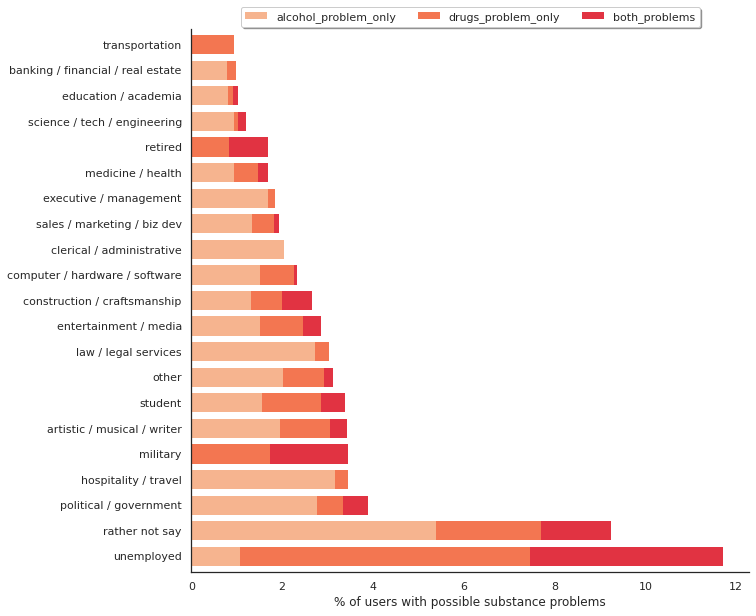

In [33]:
sns.set_style("white")

sns.set_palette("rocket_r")
sns.set_context("notebook")

jobs_stacked = df_dummy.groupby("job").mean()[['alcohol_problem_only',
                                               'drugs_problem_only',
                                               'both_problems',
                                               'abuse']].sort_values('abuse')*100
jobs_stacked.drop('abuse', axis=1, inplace=True)
jobs_stacked.plot(kind='barh', stacked=True, figsize=(10,10), width=0.75, linewidth=0)
plt.ylabel("")
plt.xlabel("% of users with possible substance problems")
plt.gca().invert_yaxis()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
sns.despine()
plt.show()

### Does having kids decrease the likelihood of substance abuse?

In [42]:
df_kids = df_dummy.dropna(axis=0, subset=["offspring"])
kids = df_kids.groupby("offspring")["abuse"].mean().to_frame()

In [43]:
kids.rename_axis("has kids")

,abuse
has kids,
0,0.027325
1,0.014981


In [65]:
# P(abuse = 1 | offspring = 1)
likelihood_abuse_T = df_kids[df_kids['abuse'] == 1]['offspring'].mean()*df_kids['abuse'].mean()
likelihood_abuse_F = df_kids[df_kids['abuse'] == 0]['offspring'].mean()*(1-df_kids['abuse'].mean())

likelihood_abuse_T/(likelihood_abuse_T + likelihood_abuse_F)

0.014981273408239699

In [66]:
# P(abuse = 1 | offspring = 0)
likelihood_abuse_T = (1-df_kids[df_kids['abuse'] == 1]['offspring'].mean())*df_kids['abuse'].mean()
likelihood_abuse_F = (1-df_kids[df_kids['abuse'] == 0]['offspring'].mean())*(1-df_kids['abuse'].mean())

likelihood_abuse_T/(likelihood_abuse_T + likelihood_abuse_F)

0.02732532265242546

### Does owning a pet help?

In [20]:
pets = df_dummy.groupby("has_pets")["abuse"].mean().to_frame()
pets

,abuse
has_pets,
False,0.022043
True,0.032704


### Substance problems grouped by religion

In [21]:
religion = df_dummy.groupby("religion")["abuse"].mean().sort_values().to_frame()
religion

,abuse
religion,
judaism,0.008979
christianity,0.012860
catholicism,0.017903
agnosticism,0.024503
other,0.026696
buddhism,0.028065
atheism,0.038092
hinduism,0.064000
islam,0.173913


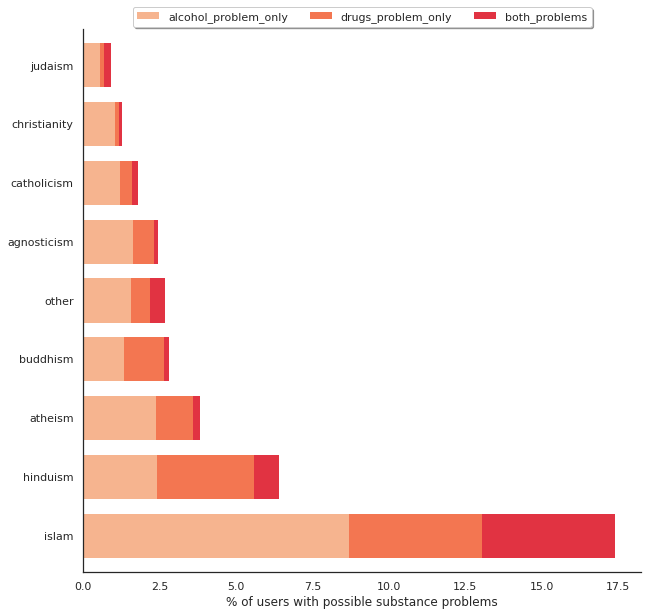

In [67]:
sns.set_style("white")

sns.set_palette("rocket_r")
sns.set_context("notebook")

religion_stacked = df_dummy.groupby("religion").mean()[['alcohol_problem_only',
                                               'drugs_problem_only',
                                               'both_problems',
                                               'abuse']].sort_values('abuse')*100
religion_stacked.drop('abuse', axis=1, inplace=True)
religion_stacked.plot(kind='barh', stacked=True, figsize=(10,10), width=0.75, linewidth=0)
plt.ylabel("")
plt.xlabel("% of users with possible substance problems")
plt.gca().invert_yaxis()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
sns.despine()
plt.show()

In [23]:
df_dummy.groupby("religion")["abuse"].sum().sort_values().to_frame()

,abuse
religion,
hinduism,8
islam,8
judaism,8
buddhism,19
christianity,25
catholicism,28
agnosticism,74
other,74
atheism,99


In [24]:
df_dummy["religion"].value_counts()

agnosticism     3020
other           2772
atheism         2599
christianity    1944
catholicism     1564
judaism          891
buddhism         677
hinduism         125
islam             46
Name: religion, dtype: int64

In [25]:
df_dummy.groupby("religious")["abuse"].mean().sort_values().to_frame()

,abuse
religious,
False,0.021947
True,0.071591
